
# 🏎️ Exploratory Data Analysis — Formula 1 Race Outcome Predictor

This notebook is part of the **F1 Race Outcome Predictor** project, which uses the [FastF1 API](https://theoehrly.github.io/Fast-F1/) and machine learning to analyze and predict Formula 1 race results.

### 📌 Objectives of this notebook:
- Load and explore race and qualifying data from the 2024 and 2025 F1 seasons
- Investigate which variables show meaningful relationships with race outcomes
- Visualize trends in driver performance, team competitiveness, and race dynamics
- Analyze multicollinearity among the influential variables. (Occam's Razor principle)
- Identify and validate features that are likely to improve the predictive performance of our machine learning model
- Clean and structure the data for future use in modeling pipelines and experiments

### 📊 Data Sources:
- [FastF1](https://theoehrly.github.io/Fast-F1/): provides timing, telemetry, and session result data via a Python API

> This notebook is intended for data exploration and insight discovery. Reusable logic (data loading, feature engineering, etc.) will be modularized into `.py` files inside the `src/` directory.

---

📁 **Project Root**: [f1-race-outcome-predictor](https://github.com/Rovsi135/F1-race-outcome-predictor)  
🧠 Authors: *Rovshan Ayyubov, Lucas van Zuijdam*  
📅 Start Date: *26/03/2025*

---

### Libraries:

### Important! 

In [7]:
import fastf1 as f1
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Suppress log messages from output
import logging
logging.getLogger("fastf1").setLevel(logging.WARNING)

### 🎯 Feature Selection: What Impacts Race Results?

Now we will start identifying which data is useful for training our machine learning model.  
To do this, we'll look at the correlation between race results and different factors like **qualifying position**, **team**, and **driver**.

This will help us figure out which features actually impact race outcomes and should be included in the model.

---

### 🔍 First Up: Qualifying Position

We begin with analyzing **qualifying position** to see how much it affects final race performance. We will analyze the **$R^2$** value between the qualifying and race results of all the races in 2024. First we have to prepare data by combining the qualifying results from all races into one dataframe:

In [25]:
#Use a list to store the dataframes that has been generated through the loop
#to concatenate them after the loop. 
list_qualifying_dataframes = []
for i in range(1, 25): #Iterate over (24) weekends
    #Load race session
    session = f1.get_session(2024, i, "Race")
    session.load(telemetry=False, laps=False, weather=False, messages=False)

    #Transfer information to a dataframe
    df_Race = session.results[["TeamName", "Abbreviation", "Position", "GridPosition", "Status"]].copy()
    df_Race["Round"] = i
    df_Race.rename(columns={"GridPosition": "QPosition"}, inplace=True)

    #Store the dataframe in a list to concatenate after
    list_qualifying_dataframes.append(df_Race)

df_2024_all_races = pd.concat(list_qualifying_dataframes, ignore_index=True, axis=0)

#extract the did not finish occurences
df_2024_all_races_wo_dnf = df_2024_all_races[df_2024_all_races["Status"] != "Retired"]
df_2024_all_races_wo_dnf


,TeamName,Abbreviation,Position,QPosition,Status,Round
0,Red Bull Racing,VER,1.0,1.0,Finished,1
1,Red Bull Racing,PER,2.0,5.0,Finished,1
2,Ferrari,SAI,3.0,4.0,Finished,1
3,Ferrari,LEC,4.0,2.0,Finished,1
4,Mercedes,RUS,5.0,3.0,Finished,1
...,...,...,...,...,...,...
471,Kick Sauber,ZHO,13.0,15.0,Lapped,24
472,Aston Martin,STR,14.0,13.0,Lapped,24
473,Alpine,DOO,15.0,17.0,Lapped,24
474,Haas F1 Team,MAG,16.0,14.0,Lapped,24


Text(0.5, 1.0, 'Qualifying vs Race Results - All Races 2024')

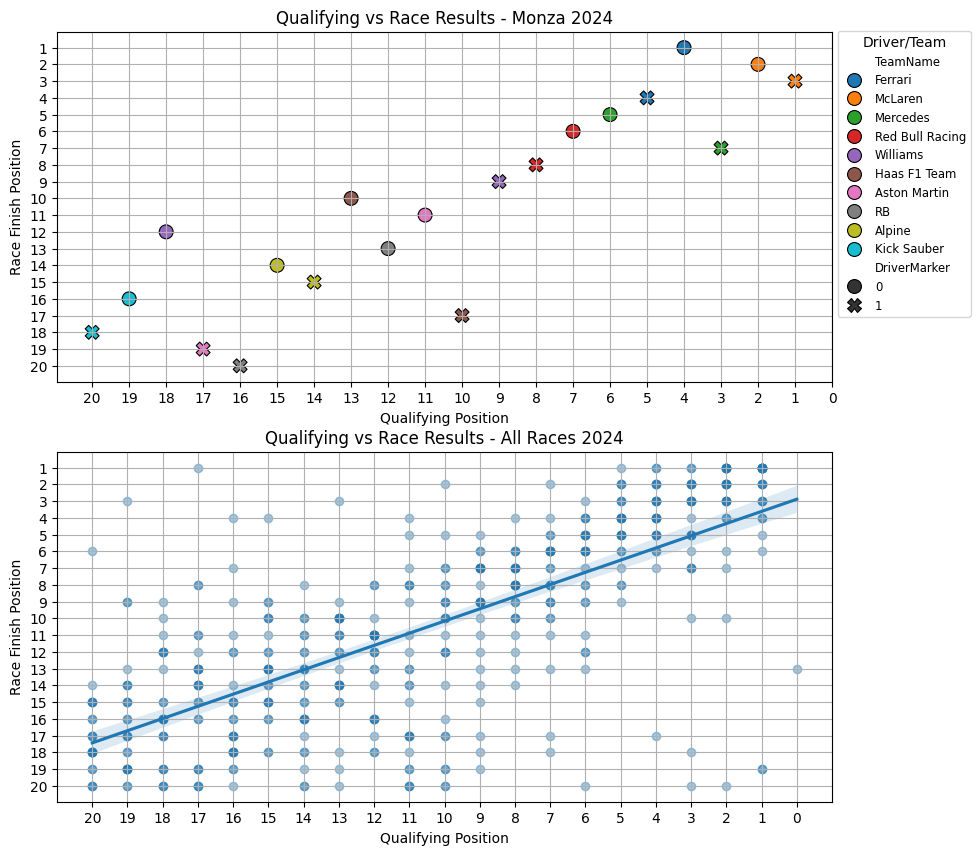

In [ ]:
#To assign different marker for different drivers for each team
df_2024_all_races['DriverMarker'] = df_2024_all_races.groupby('TeamName').cumcount() % 2

#For 1 unit length grid line:
x_min, x_max = int(df_2024_all_races['QPosition'].min()), int(df_2024_all_races['QPosition'].max())
y_min, y_max = int(df_2024_all_races['Position'].min()), int(df_2024_all_races['Position'].max())

df_2024_monza = df_2024_all_races[df_2024_all_races["Round"] == 16]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

sns.scatterplot(
    data = df_2024_monza,
    x="QPosition",
    y="Position",
    hue="TeamName",          
    style="DriverMarker", 
    s=100,                   
    edgecolor="black",      
    ax = ax[0]
)

sns.regplot(
    data=df_2024_all_races,
    x="QPosition",
    y="Position",
    #Add transparency to each data, so that when they get stacked they appear more dense
    scatter_kws={"alpha": 0.4},
    ax = ax[1]
)

for i in range(0,2):
    #Invert axises since negative correlation between best place and position 
    #e.x. 1st is the best position but smallest in terms of integer
    ax[i].invert_xaxis();
    ax[i].invert_yaxis();

    # Char ; at the end of each line suppresses the output of that column
    ax[i].set_xlabel("Qualifying Position");
    ax[i].set_ylabel("Race Finish Position");
    ax[i].grid(True);
    ax[0].legend(bbox_to_anchor=(1, 1.02), loc='upper left', fontsize='small', title="Driver/Team");
    ax[i].set_xticks(range(x_min, x_max + 1));
    ax[i].set_yticks(range(y_min, y_max + 1));

ax[0].set_title("Qualifying vs Race Results - Monza 2024");
ax[1].set_title("Qualifying vs Race Results - All Races 2024")


### 📊 Relationship Between Qualifying and Race Results

The visualizations above explore how a driver's qualifying position correlates with their final result of that race during the 2024 Formula 1 season.

- **Top Plot – Monza 2024 Only:**  
  This scatter plot shows each driver's qualifying and finishing position in the Monza GP in 2024. Teams are color-coded, and each driver within the same team have a unique marker. This gives a glimpse of a possible relationship between qualifying and race results in a single race. <br>
  *However, one event isn’t enough to confirm any strong pattern since the sample size is too small.*


- **Bottom Plot – All Races 2024:**  
  This regression plot combines data from all races in the 2024 season provide a more comprehensive view. Each point represents a driver's qualifying and finishing position in a given race. A regression line is fitted to the data, giving a sense of the overall trend: **better qualifying positions generally lead to better race results**.

These plots give us a starting point for building a predictive model, suggesting that where a driver qualifies probably influences where they finish.


### 📈 Regression Model and $R^2$ Value

Now we proceed by training a simple regression model to evaluate the relationship between qualifying results and race outcomes.  
By calculating the coefficient of determination ($R^2$), we can measure how well qualifying position explains the variation in final race position across the 2024 season.

A higher $R^2$ value indicates a stronger predictive relationship, while a lower value suggests that qualifying alone may not be sufficient to predict race results accurately.

First we will be dividing our dataset into training and test sets:

In [32]:
df_all_races_train, df_all_races_test = train_test_split(
    df_2024_all_races, test_size=0.2, random_state=7
)

X_qualifying_req_train = df_all_races_train[["QPosition"]].copy()
y_qualifying_req_train = df_all_races_train[["Position"]].copy()

X_qualifying_req_test = df_all_races_test[["QPosition"]].copy()
y_qualifying_req_test = df_all_races_test[["Position"]].copy()

Then we can fit our linear regerssion model and produce $R^2$ value:

In [28]:

req_qualifying = LinearRegression()
req_qualifying.fit(X_qualifying_req_train, y_qualifying_req_train)
req_qualifying.score(X_qualifying_req_train, y_qualifying_req_train)


0.5389281656213463

Lets clean up the data with extracting the occurences of did not finish (DNF) and recalculate the $R^2$ again:

In [36]:
df_all_races_wo_dnf_train, df_all_races_wo_dnf_test = train_test_split(
    df_2024_all_races_wo_dnf, test_size=0.2, random_state=0
)

X_qualifying_req_train_filtered = df_all_races_wo_dnf_train[["QPosition"]].copy()
y_qualifying_req_train_filtered = df_all_races_wo_dnf_train[["Position"]].copy()

X_qualifying_req_test_filtered = df_all_races_wo_dnf_test[["QPosition"]].copy()
y_qualifying_req_test_filtered = df_all_races_wo_dnf_test[["Position"]].copy()


req_qualifying_filtered = LinearRegression()
req_qualifying_filtered.fit(X_qualifying_req_train_filtered, y_qualifying_req_train_filtered)
req_qualifying_filtered.score(X_qualifying_req_train_filtered, y_qualifying_req_train_filtered), req_qualifying_filtered.score(X_qualifying_req_test_filtered, y_qualifying_req_test_filtered)


(0.6066814195420915, 0.5032536339492655)